# Context
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

# About Dataset
As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-to-day communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative anonymity
of the internet makes such personal attacks more difficult to stop than traditional bullying.

On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

# Variables
In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

__Age  
Ethnicity  
Gender  
Religion  
Other type of cyberbullying  
Not cyberbullying__

# Objective
The objective of this project is to create a model that can automatically flag potentially harmful tweets as well as break down the patterns of hatred

# Importing Libraries

In [4]:
pip install plotly==5.14.1

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86177\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Getting data

In [7]:
data = pd.read_csv('cyberbullying_tweets.csv')

# Initial Review

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [9]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


# Checking Missing Values

In [10]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## No Missing Values found!

In [11]:
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Renaming columns for better understanding

In [12]:
data = data.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [13]:
data.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Adding Encoded column for sentiments

In [14]:
data["sentiment_encoded"] = data['sentiment'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying": 5,"not_cyberbullying": 6})

In [15]:
data.head()

,text,sentiment,sentiment_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [16]:
stop_words = set(stopwords.words('english'))

# Preprocessing of Text

## Function to Remove Emojis

In [17]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

## Fucntion to Convert text to lowercase, remove (/r, /n  characters), URLs, non-utf characters, Numbers, punctuations,stopwords

In [18]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## Function to remove contractions

In [19]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

## Function to Clean Hashtags

In [20]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

## Function to Filter Special Characters such as $, &

In [21]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

## Function to remove mutiple sequence spaces

In [22]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


## Function to apply stemming to words

In [23]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

## Function to apply lemmatization to words

In [24]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

## Function to Preprocess the text by applying all above functions

In [25]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [26]:
data['cleaned_text'] = data['text'].apply(preprocess)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...


## Cleaned text added

## Dealing with Duplicates

In [27]:
data["cleaned_text"].duplicated().sum()

3041

In [28]:
data.drop_duplicates("cleaned_text", inplace=True)

# Duplicates removed

# Tokenization

In [29]:
data['tweet_list'] = data['cleaned_text'].apply(word_tokenize)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


# Checking length of various tweet texts

In [30]:
text_len = []
for text in data.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
data['text_len'] = text_len

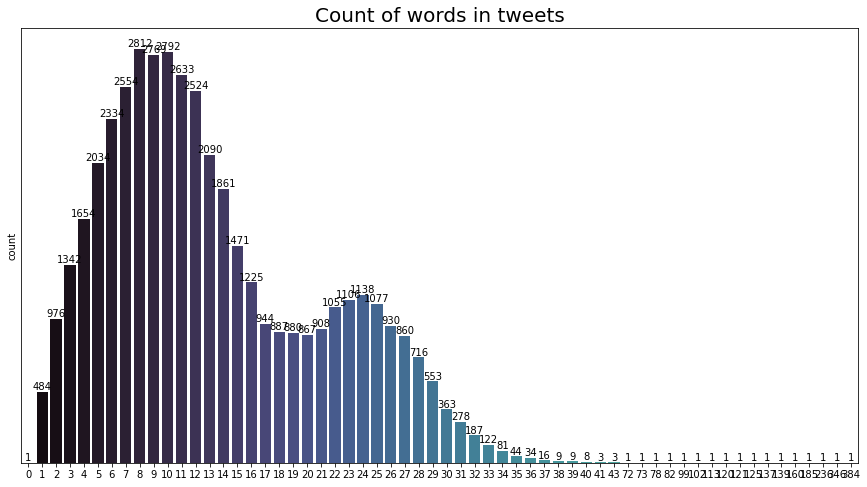

In [31]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=data, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Removing text without words

In [32]:
data = data[data['text_len']!=0]

In [33]:
data.shape

(44650, 6)

# Function to create WordCloud

In [34]:
def plot_wordcloud(cyberbullying_type):
    string = ""
    for i in data[data.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()

    
    
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256,
               random_state=42,
                min_font_size = 10).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

# Splitting data based on sentiment for Data Exploration

In [35]:
not_cyberbullying_type = data[data['sentiment']=='not_cyberbullying']
gender_type = data[data['sentiment']=='gender']
religion_type = data[data['sentiment']=='religion']
other_cyberbullying_type = data[data['sentiment']=='other_cyberbullying']
age_type = data[data['sentiment']=='age']
ethnicity_type = data[data['sentiment']=='ethnicity']

# Exploratory Data Analysis

# Gender Based Cyberbullying

In [36]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,5179
1,rape,4070
2,gay,3852
3,call,1401
4,make,1283
5,rt,1221
6,woman,1182
7,bitch,1146
8,femal,1108
9,peopl,988


Text(0.5, 1.0, 'Top 20 words in Gender Cyberbullying')

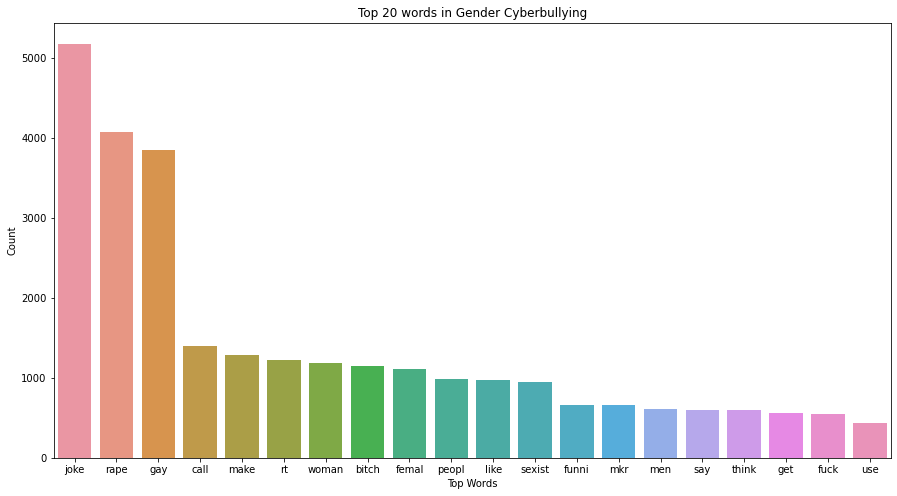

In [37]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words in Gender Cyberbullying")

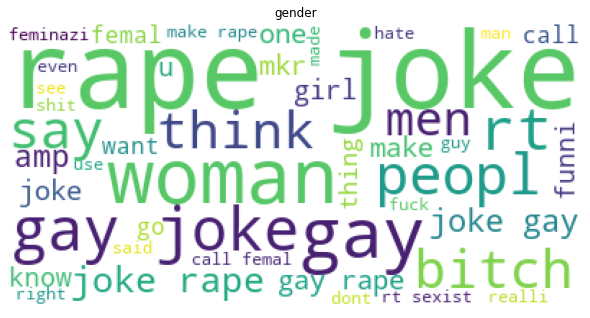

In [38]:
plot_wordcloud('gender')

# Religion Based Cyberbullying

In [39]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words','Count']
top20_religion.style.background_gradient(cmap='Greens')

,Top Words,Count
0,muslim,4618
1,idiot,3075
2,islam,2440
3,christian,2132
4,u,1922
5,terrorist,1378
6,right,1289
7,like,1276
8,support,1251
9,woman,1247


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

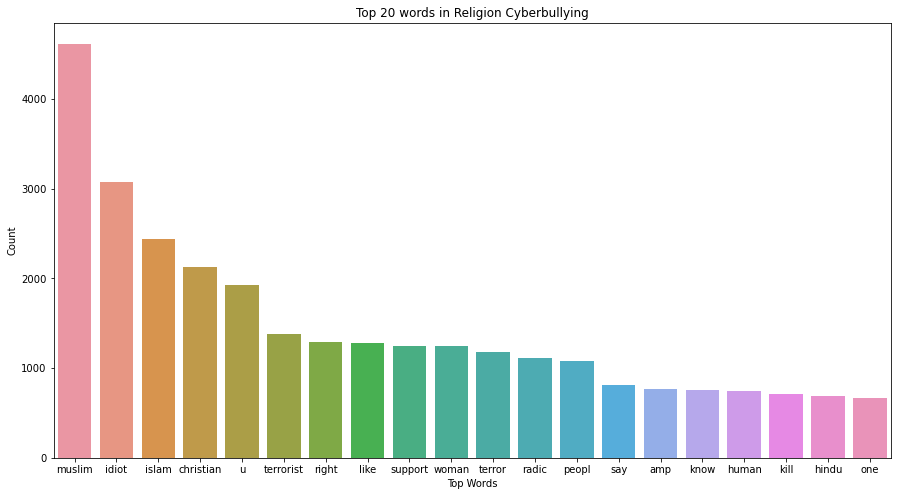

In [40]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

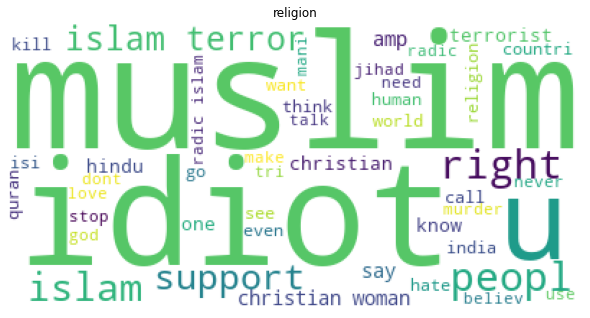

In [41]:
plot_wordcloud('religion')

# Age based Cyberbullying

In [42]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words','Count']
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8899
1,school,8426
2,high,4861
3,girl,4616
4,like,2076
5,get,1051
6,one,1044
7,peopl,934
8,got,842
9,kid,809


Text(0.5, 1.0, 'Top 20 words in Age Cyberbullying')

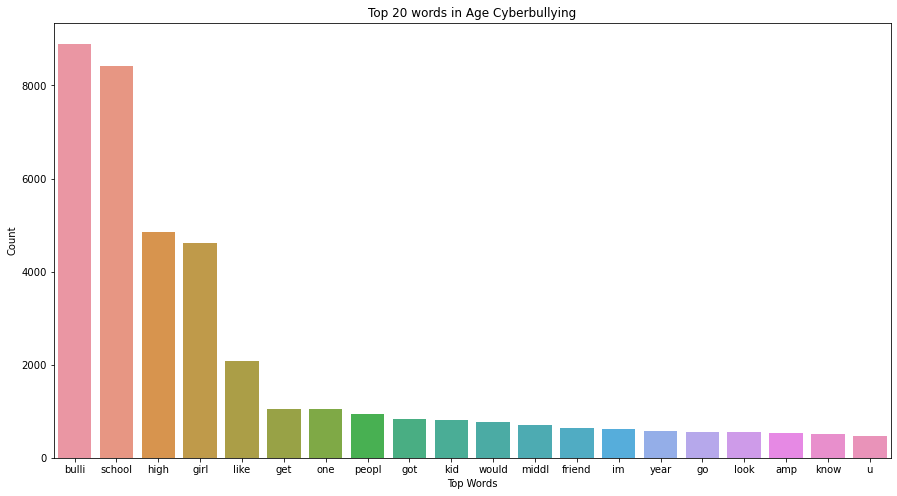

In [43]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words in Age Cyberbullying")

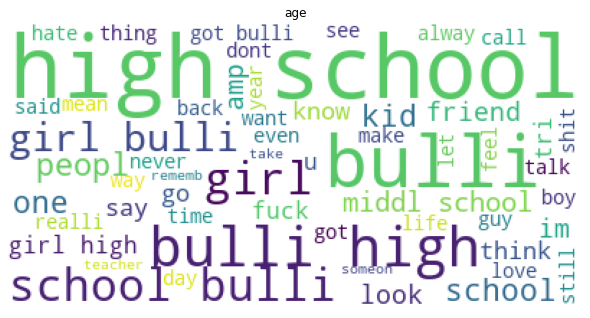

In [44]:
plot_wordcloud('age')

# Ethnicity based Cyberbullying

In [45]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5892
1,nigger,5456
2,dumb,5003
3,as,2241
4,black,2134
5,u,2107
6,white,1557
7,call,1381
8,peopl,1182
9,rt,1166


Text(0.5, 1.0, 'Top 20 words in Ethnicity Cyberbullying')

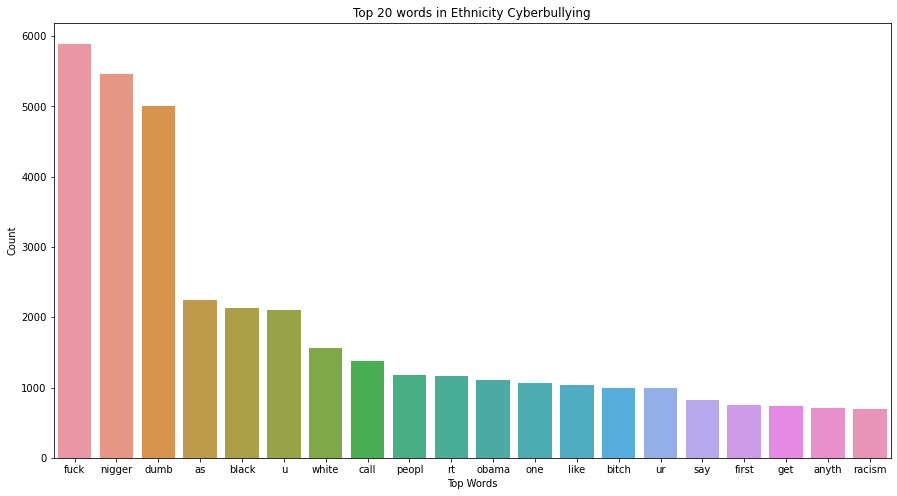

In [46]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

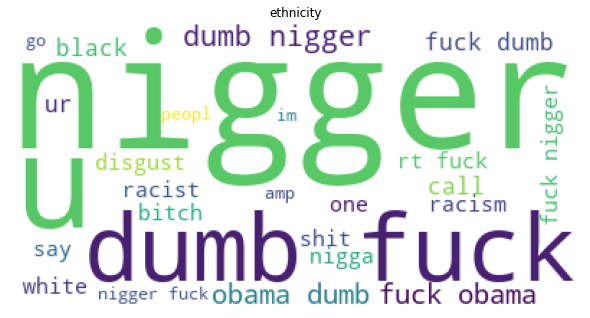

In [47]:
plot_wordcloud('ethnicity')

# Other types of Cyberbullying

In [48]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,882
1,rt,727
2,fuck,509
3,like,424
4,get,393
5,peopl,353
6,go,277
7,idiot,261
8,know,241
9,think,237


Text(0.5, 1.0, 'Top 20 words in Other Cyberbullying')

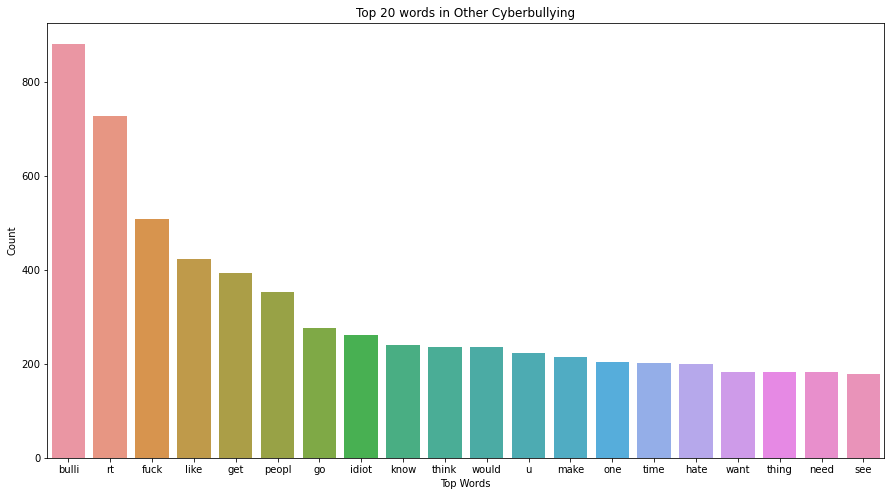

In [49]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Other Cyberbullying")

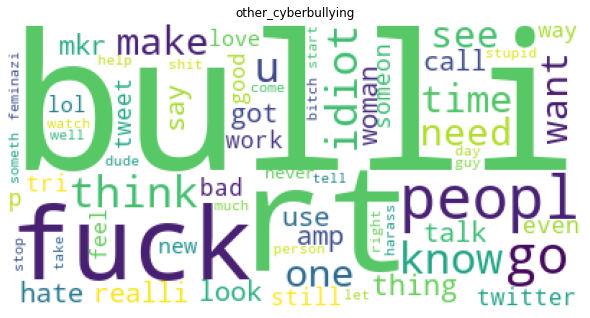

In [50]:
plot_wordcloud('other_cyberbullying')

# Tweets without Cyberbullying

In [51]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words','Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1674
1,bulli,1102
2,rt,785
3,like,424
4,get,423
5,go,394
6,school,374
7,kat,286
8,would,286
9,peopl,272


Text(0.5, 1.0, 'Top 20 words in Not Cyberbullying')

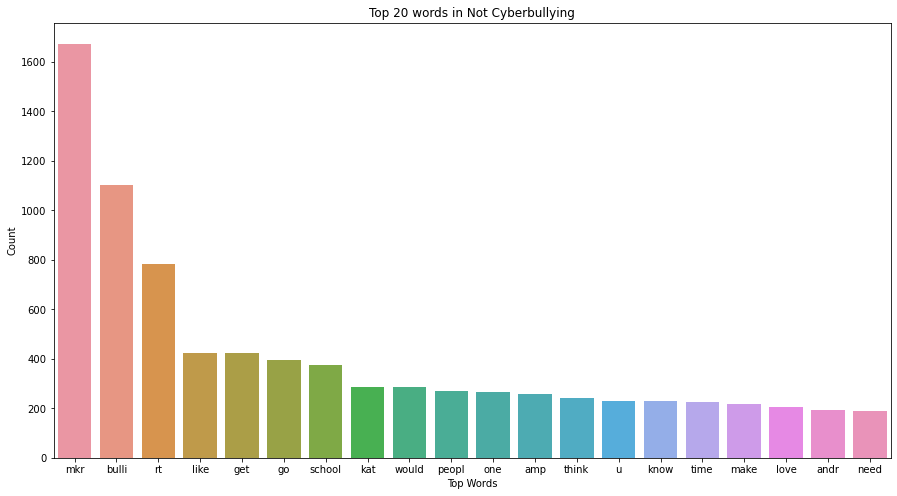

In [52]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not Cyberbullying")

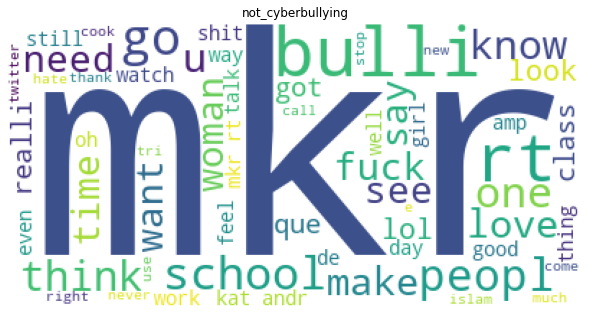

In [53]:
plot_wordcloud('not_cyberbullying')

In [54]:
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [55]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]

# Splitting Data into Train and Test Sets

In [61]:
data1 = pd.read_csv('test.csv')
data1 = data1.rename(columns={'tweet_text': 'text'})
data1['cleaned_text'] = data1['text'].apply(preprocess)
data1.head()


,text,cleaned_text
0,your are a faggot,faggot


In [ ]:
test11 = data1['cleaned_text']

In [ ]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
test11_tf = tf_idf.transform(test11)

print(test11_tf.shape)

(1, 29111)


In [64]:
X,Y = data['cleaned_text'],data['sentiment_encoded']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(31255,) (31255,) (13395,) (13395,)


In [ ]:
X_test.head()

41596    realli whoever made pictur honestli go die dum...
6263                                well support lost mine
17071    look like daeshbag complet broken flee koban area
21191                   vote prevent muslim genocid israel
38088    exampl sunset shimmer villain mlp equestria gi...
Name: cleaned_text, dtype: object

## tf-idf Vectorization

In [66]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(31255, 29111)
(13395, 29111)


# Trying Different ML Models

## Logistic Regression

In [ ]:
log_reg = LogisticRegression()

In [ ]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [ ]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.8228272280708214

## Support Vector Classifier

In [ ]:
lin_svc = LinearSVC()

In [ ]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.8220066371295554

## Naive Bayes Classifier

In [ ]:
multiNB = MultinomialNB()

In [ ]:
multiNB_cv_score = cross_val_score(multiNB,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.6708019945279682

## Decison Tree Classifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree_cv_score = cross_val_score(dtree,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.8070335892983305

## RandomForest Classifier 

In [ ]:
rand_forest = RandomForestClassifier()

In [ ]:
rand_forest_cv_score = cross_val_score(rand_forest,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

0.8300522572964468

## Adaboost Classifier

In [ ]:
adab = AdaBoostClassifier()

In [ ]:
adab_cv_score = cross_val_score(adab,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

0.7600790583302414

## By trying different models we can see logistic regression, svm and random forest classifier performed similarly, so among these we will go with svm model as it is more generalised and light

## Fine Tuning Support Vector Classifier

In [ ]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [ ]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [ ]:
grid_search.best_score_

0.8244012024546198

## Random Forest

In [ ]:
rand_forest1 = RandomForestClassifier()
param_grid = {'n_estimators': [10, 100,1000],
    'max_features': ['sqrt', 'log2',None],
    'criterion' :['gini', 'entropy','log_loss'],
    'bootstrap':[True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    }
grid_search = GridSearchCV(rand_forest1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_score_

# Model Evaluation

In [ ]:
lin_svc.fit(X_train_tf,y_train)
y_pred = lin_svc.predict(X_test_tf)

In [ ]:
y_pred1 = lin_svc.predict(test11_tf)

In [ ]:
print(y_pred1)

[4]


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

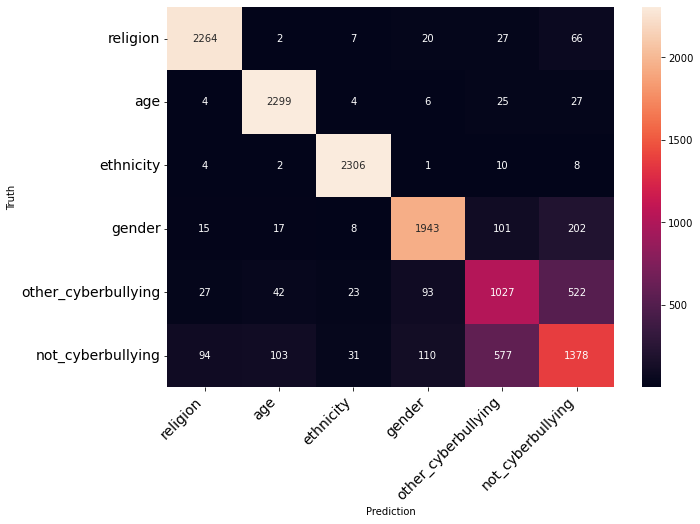

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

In [33]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.94      0.95      0.94      2386
                age       0.93      0.97      0.95      2365
          ethnicity       0.97      0.99      0.98      2331
             gender       0.89      0.85      0.87      2286
other_cyberbullying       0.58      0.59      0.59      1734
  not_cyberbullying       0.63      0.60      0.61      2293

           accuracy                           0.84     13395
          macro avg       0.82      0.83      0.82     13395
       weighted avg       0.84      0.84      0.84     13395



# Saving Model 

In [105]:
pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))
pickle.dump(lin_svc, open('model.pkl', 'wb'))

In [107]:
pip install sklearn2pmml


  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.92.0-py3-none-any.whl size=6483706 sha256=46c9f4d239ce324d776bc14f92507605e2b4c5d67e70c9dbf69cde6cf997d90c
  Stored in directory: c:\users\86177\appdata\local\pip\cache\wheels\c9\84\ca\6b3025f8ed6d2e815ecf7de79f952d9785e1275d4cf6aeb47f
Successfully built sklearn2pmml


In [34]:
from sklearn2pmml import PMMLPipeline, sklearn2pmml

In [57]:
FILE = 'demo.model'

def convert(file):
    mod = lin_svc()
    mod.load_model(file)
    pipe = PMMLPipeline([
        ("classifier", mod),
    ])

    sklearn2pmml(pipe, file + '.pmml', with_repr=True)
    
convert(FILE)

NameError: name 'lin_svc' is not defined

In [58]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import LinearSVC

In [59]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn2pmml import PMMLPipeline, sklearn2pmml
import pandas as pd

In [121]:
# fetching data example
df12 = load_diabetes()
df12

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [122]:
df12.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [124]:
X12 = pd.DataFrame(columns = df12.feature_names, data = df12.get('data'))
X12

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


In [126]:
y12 = pd.DataFrame(columns = ['target'], data = df12.get('target'))
y12

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0
...,...
437,178.0
438,104.0
439,132.0
440,220.0


In [133]:

X,Y = data['cleaned_text'],data['sentiment_encoded']
X

0                       word katandandr food crapilici mkr
1        aussietv white mkr theblock imacelebrityau tod...
2                           classi whore red velvet cupcak
3        meh p thank head concern anoth angri dude twitter
4        isi account pretend kurdish account like islam...
                               ...                        
47687    black ppl expect anyth depend anyth yet free p...
47688    turner withhold disappoint turner call court a...
47689    swear god dumb nigger bitch got bleach hair re...
47690    yea fuck rt your nigger fuck unfollow fuck dum...
47691    bro u got ta chill rt dog fuck kp dumb nigger ...
Name: cleaned_text, Length: 44650, dtype: object

In [137]:
xdf = pd.DataFrame(data, columns=['cleaned_text'])
xdf

,cleaned_text
0,word katandandr food crapilici mkr
1,aussietv white mkr theblock imacelebrityau tod...
2,classi whore red velvet cupcak
3,meh p thank head concern anoth angri dude twitter
4,isi account pretend kurdish account like islam...
...,...
47687,black ppl expect anyth depend anyth yet free p...
47688,turner withhold disappoint turner call court a...
47689,swear god dumb nigger bitch got bleach hair re...
47690,yea fuck rt your nigger fuck unfollow fuck dum...


In [138]:
ydf = pd.DataFrame(data, columns=['sentiment_encoded'])
ydf

,sentiment_encoded
0,6
1,6
2,6
3,6
4,6
...,...
47687,3
47688,3
47689,3
47690,3


In [129]:
Y

0        6
1        6
2        6
3        6
4        6
        ..
47687    3
47688    3
47689    3
47690    3
47691    3
Name: sentiment_encoded, Length: 44650, dtype: int64

In [75]:
data['cleaned_text'] = data['cleaned_text'].apply(lambda word: " ".join(word)) 
X

0        w o r d   k a t a n d a n d r   f o o d   c r ...
1        a u s s i e t v   w h i t e   m k r   t h e b ...
2        c l a s s i   w h o r e   r e d   v e l v e t ...
3        m e h   p   t h a n k   h e a d   c o n c e r ...
4        i s i   a c c o u n t   p r e t e n d   k u r ...
                               ...                        
47687    b l a c k   p p l   e x p e c t   a n y t h   ...
47688    t u r n e r   w i t h h o l d   d i s a p p o ...
47689    s w e a r   g o d   d u m b   n i g g e r   b ...
47690    y e a   f u c k   r t   y o u r   n i g g e r ...
47691    b r o   u   g o t   t a   c h i l l   r t   d ...
Name: cleaned_text, Length: 44650, dtype: object

In [77]:
tf_idf = TfidfVectorizer(analyzer = "char")
pipeline = PMMLPipeline([ ("vect", tf_idf) ])
#training the model
pipeline.fit(X)
# exporting the model
sklearn2pmml(pipeline, 'tfidf.pmml', with_repr = True)

Standard output is empty
Standard error:
Exception in thread "main" java.lang.IllegalArgumentException: l2
	at sklearn.feature_extraction.text.TfidfVectorizer.encodeFeatures(TfidfVectorizer.java:74)
	at sklearn.Transformer.encode(Transformer.java:70)
	at sklearn.Composite.encodeFeatures(Composite.java:119)
	at sklearn2pmml.pipeline.PMMLPipeline.encodePMML(PMMLPipeline.java:154)
	at com.sklearn2pmml.Main.run(Main.java:91)
	at com.sklearn2pmml.Main.main(Main.java:66)



RuntimeError: The SkLearn2PMML application has failed. The Java executable should have printed more information about the failure into its standard output and/or standard error streams

In [79]:


mod = LinearSVC(C=1, loss='hinge')
# here you can use the key classifier, if suitable
pipeline = PMMLPipeline([("model", mod) ])
#training the model
pipeline.fit(X_train_tf,y_train)
# exporting the model
sklearn2pmml(pipeline, 'model.pmml', with_repr = True)

Exception in thread Thread-26:
Traceback (most recent call last):
  File "c:\Users\86177\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\86177\anaconda3\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\86177\anaconda3\lib\subprocess.py", line 1479, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\86177\anaconda3\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 77: invalid start byte


In [118]:


feature_names = 'cleaned_text'
target_name = "sentiment_encoded"
pipeline_obj = Pipeline([
    ('mapper', DataFrameMapper([

        ('cleaned_text', TfidfVectorizer())
   
])),
 ('model',LinearSVC())
])

pipeline_obj.fit(X,Y)

KeyError: 'tweet_text'